# Reading NetCDF's using Xarray to Pandas DataFrame
## Satellite Image Processing / BioCAST Seed Creation

Includes references to plotting using Matplotlib and related tools.

This program reads in two inputs: 1) APS level 4 satellite image 7 Day composite 2) BioCast generated advection product.  Both are NetCDF's.
The program's goal is to read the inputs, store them, and perform a union of the data with a basic gaussian smoothing to create a "full" image (sometimes a problem due to cloud coverage).
Output the data using NetCDF Best Practices, APS meta-data as an authoritative source, and custom meta-data geared towards future requirements.

## *Xarray*

007 reads a NetCDF via the netCDF4 library which appears to present no real problems.  Whether due to lack of understanding, skill or design moving a NetCDF into a Panda's Dataframe, as presented in this work, is cumbersome.  Xarray is to multi-dimensional data what Pandas is to 1D/2D data.  Xarray provides very strong convenience routines as well.

http://xarray.pydata.org/en/stable/index.html

xarray: N-D labeled arrays and datasets in Python

xarray (formerly xray) is an open source project and Python package that makes working with labelled multi-dimensional arrays simple, efficient, and fun!

Xarray introduces labels in the form of dimensions, coordinates and attributes on top of raw NumPy-like arrays, which allows for a more intuitive, more concise, and less error-prone developer experience. The package includes a large and growing library of domain-agnostic functions for advanced analytics and visualization with these data structures.

Xarray is inspired by and borrows heavily from pandas, the popular data analysis package focused on labelled tabular data. It is particularly tailored to working with netCDF files, which were the source of xarray’s data model, and integrates tightly with dask for parallel computing.

In [1]:
import tensorflow as tf

In [2]:
# Python 3.7.3
############################################
# INCLUDES
############################################
#libraries specific to this example
#Data Science Libraries
import numpy as np
import pandas as pd
###-> this is IT
import xarray as xr
import scipy as sp
import scipy.ndimage

#a set of libraries that perhaps should always be in Python source
import os 
import datetime
import sys
import gc
import getopt
import inspect
import math
import warnings

#a darn useful library for creating paths and one I recommend you load to your environment
from pathlib import Path

from pydoc import help                          # can type in the python console `help(name of function)` to get the documentation

#Plotting libraries
import matplotlib as matplt
import matplotlib.pyplot as plt
import seaborn as sns
import cartopy.crs as ccrs

# for NetCDF output
import netCDF4 as nc
from netCDF4 import Dataset

#Import a custom library, in this case a fairly useful logging framework
debug_lib_location = Path("./")
sys.path.append(str(debug_lib_location))
import debug

warnings.filterwarnings('ignore')               # don't print out warnings


root_location="." + os.sep + "data";
#root_location="C:\\Users\\cwood\\Documents\\jbooks\\data"

In [3]:
############################################
#JUPYTER NOTEBOOK OUTPUT CONTROL / FORMATTING
############################################
#set floating point to 4 places to things don't run loose
pd.options.display.float_format = '{:,.4f}'.format
np.set_printoptions(precision=4)

# Variable declaration

In [4]:
############################################
# GLOBAL VARIABLES
############################################
DEBUG = 1                            #General ledger output so you know what's happening.
DEBUG_DATA = 1                       #Extremely verbose output, change to zero (0) to supress the volume of output.

# CODE CONSTRAINTS
VERSION_NAME    = "Xarray"
VERSION_ACRONYM = "XRAY"
VERSION_MAJOR   = 0
VERSION_MINOR   = 0
VERSION_RELEASE = 1
VERSION_TITLE   = VERSION_NAME + " (" + VERSION_ACRONYM + ") " + str(VERSION_MAJOR) + "." + str(VERSION_MINOR) + "." + str(VERSION_RELEASE) + " generated SEED."

FILL_VALUE=-32767.0 
ENCODING  ="utf-8"
############################################
# GLOBAL CONSTANTS
############################################
    

############################################
# APPLICATION VARIABLES
############################################
geospatial_lat_nm='lat'
geospatial_lon_nm='lon'
aps_lat_nm="y"
aps_lon_nm="x"

############################################
# GLOBAL CONFIGURATION
############################################
os.environ['PYTHONIOENCODING']=ENCODING


In [5]:
def lib_diagnostics():
    debug.msg_debug("System version    #:{:>12}".format(sys.version))
    netcdf4_version_info = nc.getlibversion().split(" ")
    debug.msg_debug("netCDF4 version   #:{:>12}".format(netcdf4_version_info[0]))
    debug.msg_debug("Matplotlib version#:{:>12}".format(matplt.__version__))
    debug.msg_debug("Numpy version     #:{:>12}".format(np.__version__))
    debug.msg_debug("Xarray version    #:{:>12}".format(xr.__version__))
    debug.msg_debug("Pandas version    #:{:>12}".format(pd.__version__))
    debug.msg_debug("SciPy version     #:{:>12}".format(sp.__version__))
   
    return

# Main Method - setup environment to support program execution
## Define filenames

In [6]:
############################################
# MAIN
############################################
#try:
#     opts, args = getopt.getopt(
#          argv, "VvHhB:b:A:a::O:o:c:", ["afile=", "bfile=", "ofile=", "clobber="]
#      )
#except getopt.GetoptError:
#      printusage()
#      sys.exit(2)
#argument_management(opts, args)

warnings.filterwarnings("ignore")


#Setup filenames
#aps_filename    =root_location+os.sep+"npp.201997.MMDD.2019103.0413.D.L4-7DLP.viirsn.MissBight.v08.750m.nc"
the_filename    =root_location+os.sep+"MissBight_2020010900.nc"

debug.msg_info("Started " + str(VERSION_NAME) + ".")

debug.msg_info(" ")
debug.msg_debug("...library versioning output")
lib_diagnostics()
debug.msg_info(" ")
debug.msg_debug("    APS Filename: "+the_filename)

[2022-09-07 16:39:14 CDT]    INFO: Started Xarray. 
[2022-09-07 16:39:14 CDT]    INFO:   
[2022-09-07 16:39:14 CDT]   DEBUG: ...library versioning output 
[2022-09-07 16:39:14 CDT]   DEBUG: System version    #:3.7.10 | packaged by conda-forge | (default, Feb 19 2021, 16:07:37) 
[GCC 9.3.0] 
[2022-09-07 16:39:14 CDT]   DEBUG: netCDF4 version   #:       4.7.4 
[2022-09-07 16:39:14 CDT]   DEBUG: Matplotlib version#:       3.4.2 
[2022-09-07 16:39:14 CDT]   DEBUG: Numpy version     #:      1.21.1 
[2022-09-07 16:39:14 CDT]   DEBUG: Xarray version    #:      0.19.0 
[2022-09-07 16:39:14 CDT]   DEBUG: Pandas version    #:       1.3.1 
[2022-09-07 16:39:14 CDT]   DEBUG: SciPy version     #:       1.7.1 
[2022-09-07 16:39:14 CDT]    INFO:   
[2022-09-07 16:39:14 CDT]   DEBUG:     APS Filename: ./data/MissBight_2020010900.nc 


# Read Input NetCDF Files

In [7]:
#READ Input NetCDF
#argument management has already handled existence, validity, etc.

#write defensive code that fails fast, use try/exceptions where it makes sense.
try:
    the_netcdf = Dataset(the_filename, "r", format="NETCDF4")
except Exception as e:
    debug.msg_error("Error encountered while reading initial netCDF4 NetCDF: " + str(e))

try:
    the_xarray = xr.open_dataset(the_filename)    
except Exception as e:
    debug.msg_error("Error encountered while reading initial Xarray NetCDF: "+ str(e))

In [8]:
#just a quick dump to show the contents of the read, variables are at the bottom of the stack.
the_netcdf

<class 'netCDF4._netCDF4.Dataset'>
root group (NETCDF3_CLASSIC data model, file format NETCDF3):
    source: BioCAST 1.1.5
    title: ./MissBight_2020010900.nc
    version: 1.1.5
    rp_organization: NAVOCEANO
    rp_phone: 228-688-5176
    rp_email: cso.navo.fct@navy.mil
    rp_name: NAVOCEANO CSO
    conventions: National System for Geospatial Integlligence (NSG) Meatadata Foundation (NMF), Version 3.0, 2016-08-31 (NGA.STD.0012-3.0)
    geoBoundingBox_northBoundLatitude: 31.0065
    geoBoundingBox_southBoundLatitude: 28.3900
    geoBoundingBox_eastBoundLongitude: -84.5053
    geoBoundingBox_westBoundLongitude: -90.5075
    geoDescription: Pseudo-Mercator
    referenceSystem_code: Geodetic Geographic 3D
    referenceSystem_title: EPSG:4326 (WGS 84)
    createDate: 2020-03-24 10:59:00
    start_date: 2020-01-09
    start_time: 00:00:00
    stop_date: 2020-01-09
    stop_time: 00:00:00
    lineage: Generated by BioCAST 1.1.5 using optics seed /export/tods-rt/biocast3D/biocast_data/npp.2

In [9]:
#display of XARRAY
the_xarray

<xarray.Dataset>
Dimensions:  (lon: 800, lat: 400, depth: 29, time: 1)
Coordinates:
  * lon      (lon) float32 -90.5 -90.49 -90.48 -90.48 ... -84.51 -84.51 -84.5
  * lat      (lat) float32 31.0 30.99 30.99 30.98 ... 28.4 28.4 28.39 28.38
  * depth    (depth) float32 1.0 2.0 3.0 4.0 5.0 ... 25.0 26.0 27.0 28.0 29.0
  * time     (time) datetime64[ns] 2020-01-09
Data variables:
    chlor_a  (time, depth, lat, lon) float32 ...
Attributes: (12/50)
    source:                             BioCAST 1.1.5
    title:                              ./MissBight_2020010900.nc
    version:                            1.1.5
    rp_organization:                    NAVOCEANO
    rp_phone:                           228-688-5176
    rp_email:                           cso.navo.fct@navy.mil
    ...                                 ...
    aps_inputParameters:                -m LAND,ATMFAIL,CLDICE,SPARE3,ATMWARN...
    aps_start_date:                     2020-01-06
    aps_start_time:                     18:54:22
    aps_stop_date:                      2020-01-13
    aps_stop_time:                      20:05:18
    aps_prodList:                       chlor_a

# Get a Quick view of the data (netCDF4 libs)

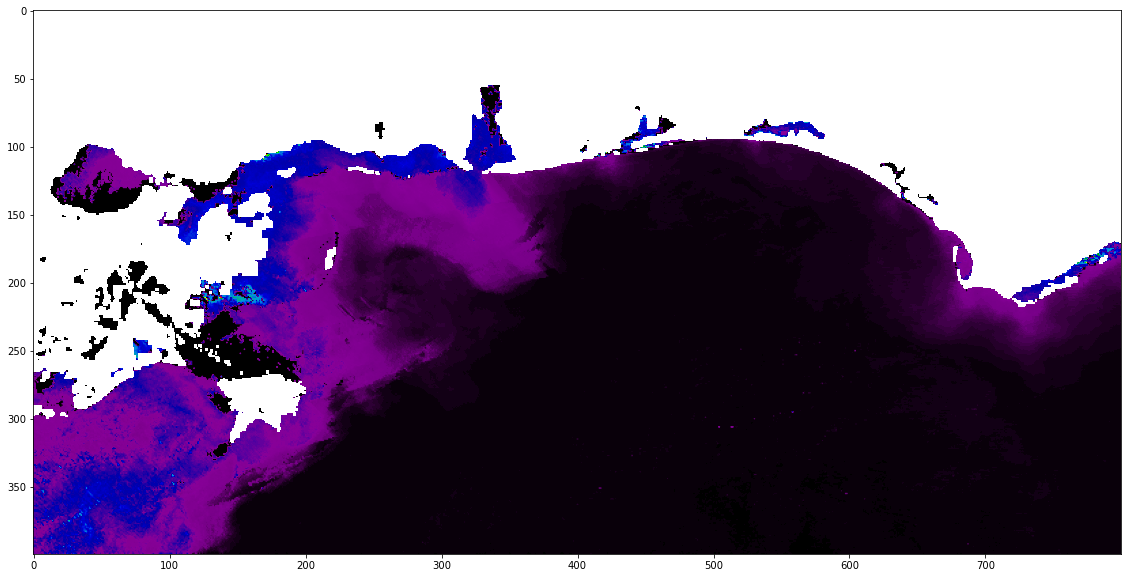

In [11]:
from matplotlib import pyplot as plt

plt.figure(figsize = (40,10))
#notice the indexing of the array [time, depth, lat, lon], the ":" means everything
plt.imshow(the_netcdf["chlor_a"][0][0][:][:],cmap='nipy_spectral')

# Get a Quick view of the data (Xarray libs)

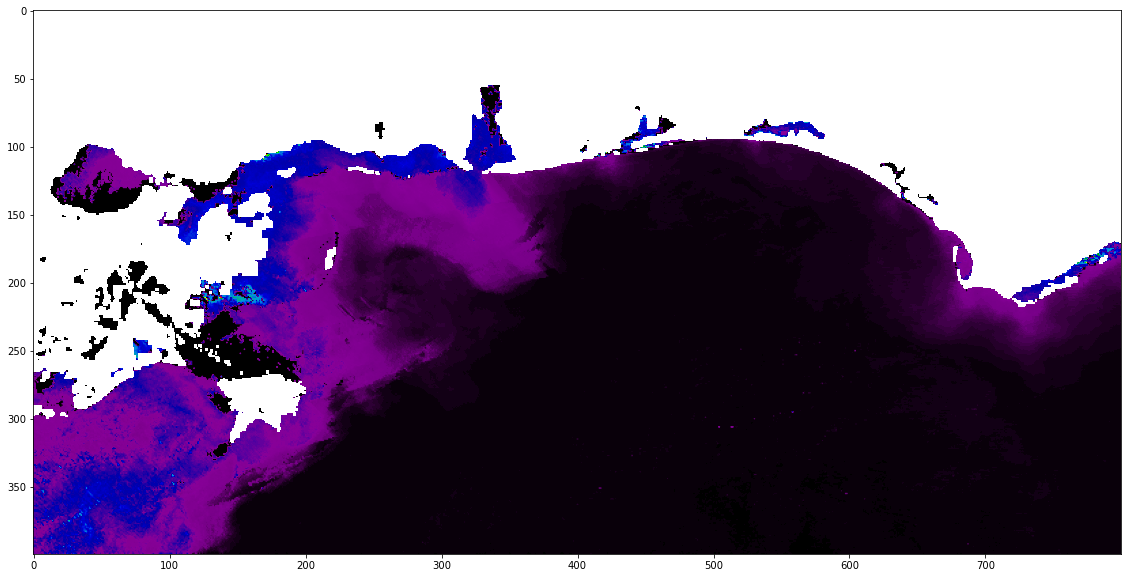

In [13]:
from matplotlib import pyplot as plt

plt.figure(figsize = (40,10))
#notice the indexing of the array [time, depth, lat, lon], the ":" means everything
plt.imshow(the_xarray["chlor_a"][0][0][:][:],cmap='nipy_spectral')

## Pandas Integration (this is why you use Xarray)

In [14]:
df=the_xarray.to_dataframe()
#yeah...you're done

In [15]:
#quick view to show what's inside
df

chlor_a
lon      lat     depth   time               
-90.5000 31.0000 1.0000  2020-01-09      NaN
                 2.0000  2020-01-09      NaN
                 3.0000  2020-01-09      NaN
                 4.0000  2020-01-09      NaN
                 5.0000  2020-01-09      NaN
...                                      ...
-84.4978 28.3833 25.0000 2020-01-09   0.3237
                 26.0000 2020-01-09   0.3237
                 27.0000 2020-01-09   0.3237
                 28.0000 2020-01-09   0.3237
                 29.0000 2020-01-09   0.3237

[9280000 rows x 1 columns]

In [16]:
#CLOSE ALL FILES
debug.msg_info("Closing out NetCDF files.")
try:
    the_netcdf.close()
except Exception as e:
    debug.msg_error("netCDF4 libs: Failed to close NetCDF, you could have a corrupted file. " + str(e))

try:
    the_xarray.close()
except Exception as e:
    debug.msg_error("Xarray libs: Failed to close NetCDF, you could have a corrupted file. " + str(e))


debug.msg_info("Finished " + str(VERSION_NAME) + ".")

[2022-09-07 16:39:59 CDT]    INFO: Closing out NetCDF files. 
[2022-09-07 16:39:59 CDT]    INFO: Finished Xarray. 
